# Titanic Survivor Prediction

Given the data we will try to model the chances of a passenger surviving given his attributes. 

#### 1. Data Description

We have two data sets - `train.csv` and `test.csv`. We will build and assess our model on the train dataset and predict the outcomes for the final model for the test dataset.

The dataset has nine feature variables and one target variable - `survival`. The `survival` variable takes two values -`0` and `1`, `1` implying that the passenger survived. z

The variable `pclass` is for the ticket class and takes the values `1`, `2` and `3`. It serves as a proxy for the passenger's socio-economic status. Other feature variables are `sex` - gender of the passenger, `Age` - age in years of the passenger, `sibsp` - is the number of siblings/spouses aboard the Titanic, `parch` - is the number of parents/children aboard the Titanic, `ticket` - is the ticket number of the passenger, `fare` - is the passenger fare, `cabin` - is the cabin number of the passenger and `embarked` - is the port of embarkation. 

#### 2. Data Preprocessing

In the following sections we will check for outliers, missing values and duplicates. We will check if the dataset needs to be balanced before building the model by checking the event rate. 

##### 2.1 Missing Value Treatment

In [1]:
# read the data
import pandas as pd
import os
print(os.getcwd())
os.chdir('../titanic')

/Users/shubhamgandhi/Desktop/discover


In [2]:
# read the data and check the dimensions
data = pd.read_csv('train.csv')
print(data.shape)

(891, 12)


In [3]:
# get number of missing values for each variable
print(data.isnull().sum(axis=0))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Three variables have missing values - `Age`, `cabin` and `Embarked`. We will drop the variable `cabin` as it denotes the cabin number of the passenger and doesn't represent any attribute of the passenger that can help predict his/her chance at survival. However, `Age` is an important variable. To impute the missing values in the `Age` column we will use nearest neighbors imputation. 

In [4]:
# drop the cabin variable
data.drop(['Cabin'], inplace=True,axis=1)
print(data.shape)

(891, 11)


In [5]:
# drop passenger id, ticket number name of the passenger from the dataset
data.drop(['PassengerId','Name','Ticket'], inplace=True,axis=1)
print(data.shape)
# rearrange the columns in the dataframe
data = data.loc[:,['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Survived']]

(891, 8)


In [6]:
# preview the data
print(data.head())

   Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Survived
0       3    male  22.0      1      0   7.2500        S         0
1       1  female  38.0      1      0  71.2833        C         1
2       3  female  26.0      0      0   7.9250        S         1
3       1  female  35.0      1      0  53.1000        S         1
4       3    male  35.0      0      0   8.0500        S         0


In [7]:
# knn requires all data to be numerical. We will convert Pclass, Sex and Embarked to dummy encoded variables
dm_pclass = pd.get_dummies(data.loc[:,'Pclass'],prefix='Pclass')
dm_sex = pd.get_dummies(data.loc[:,'Sex'],prefix='Sex')
dm_embarked = pd.get_dummies(data.loc[:,'Embarked'],prefix='Embarked')

data_ohe = pd.concat([data, dm_pclass, dm_sex, dm_embarked], axis=1)
data_ohe.drop(['Pclass','Sex','Embarked'],inplace=True,axis=1)
print(data_ohe.shape)

(891, 13)


In [8]:
# preview data
print(data_ohe.head())

    Age  SibSp  Parch     Fare  Survived  Pclass_1  Pclass_2  Pclass_3  \
0  22.0      1      0   7.2500         0         0         0         1   
1  38.0      1      0  71.2833         1         1         0         0   
2  26.0      0      0   7.9250         1         0         0         1   
3  35.0      1      0  53.1000         1         1         0         0   
4  35.0      0      0   8.0500         0         0         0         1   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0           0         1           0           0           1  
1           1         0           1           0           0  
2           1         0           0           0           1  
3           1         0           0           0           1  
4           0         1           0           0           1  


In [9]:
# get missing value information
import numpy as np
print(data_ohe.isnull().sum(axis=0))
print(np.isfinite(data_ohe.values).sum(axis=0))
print((np.isfinite(data_ohe.values) | np.isnan(data_ohe.values)).sum(axis=0))
print(data_ohe.shape)

Age           177
SibSp           0
Parch           0
Fare            0
Survived        0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64
[714 891 891 891 891 891 891 891 891 891 891 891 891]
[891 891 891 891 891 891 891 891 891 891 891 891 891]
(891, 13)


In [10]:
data_ohe.columns[1:13]

Index(['SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

K Nearest Neighbor is a distance based method and hence it is important to scale the data before we use it for imputing the missing values. 

In [11]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
data_ohe.loc[:,['SibSp', 'Parch', 'Fare']] = min_max.fit_transform(data_ohe.loc[:,['SibSp', 'Parch', 'Fare']])

In [12]:
# data_ohe = pd.to_numeric(data_ohe, errors='ignore')
print(data_ohe.head())

    Age  SibSp  Parch      Fare  Survived  Pclass_1  Pclass_2  Pclass_3  \
0  22.0  0.125    0.0  0.014151         0         0         0         1   
1  38.0  0.125    0.0  0.139136         1         1         0         0   
2  26.0  0.000    0.0  0.015469         1         0         0         1   
3  35.0  0.125    0.0  0.103644         1         1         0         0   
4  35.0  0.000    0.0  0.015713         0         0         0         1   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0           0         1           0           0           1  
1           1         0           1           0           0  
2           1         0           0           0           1  
3           1         0           0           0           1  
4           0         1           0           0           1  


In [13]:
print(type(data_ohe))
print(data_ohe.dtypes)

<class 'pandas.core.frame.DataFrame'>
Age           float64
SibSp         float64
Parch         float64
Fare          float64
Survived        int64
Pclass_1        uint8
Pclass_2        uint8
Pclass_3        uint8
Sex_female      uint8
Sex_male        uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object


In [14]:
print(data_ohe.shape)
print(data_ohe.columns)

(891, 13)
Index(['Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


In [15]:
# create an instance of the K Nearest Neigbhors object
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
imputer = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', 
                              leaf_size=30, p=2, metric='minkowski', metric_params=None, 
                              n_jobs=-1)
param_grid = {
    'n_neighbors': [5,8,10,12,15,20,25],
    'weights':['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],\
    'leaf_size':[10,15,20,25,30,35,40,50]
}
print(data_ohe.columns)
imputer_cv = GridSearchCV(imputer,param_grid, cv=3,verbose=True)
imputer_cv.fit(data_ohe.loc[~data_ohe.isnull().any(axis=1),['SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 
                                                            'Pclass_2','Pclass_3', 'Sex_female', 'Sex_male', 
                                                            'Embarked_C', 'Embarked_Q','Embarked_S']],
               data_ohe.loc[~data_ohe.isnull().any(axis=1),'Age'])

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')
Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=1)]: Done 1008 out of 1008 | elapsed:  4.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 8, 10, 12, 15, 20, 25], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [10, 15, 20, 25, 30, 35, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [16]:
data_ohe.loc[~data_ohe.isnull().any(axis=1),['SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 
                                                            'Pclass_2','Pclass_3', 'Sex_female', 'Sex_male', 
                                                            'Embarked_C', 'Embarked_Q','Embarked_S']].shape
data_ohe.loc[~data_ohe.isnull().any(axis=1),'Age'].shape

(714,)

In [17]:
print(imputer_cv.cv_results_)

{'mean_fit_time': array([ 0.00210738,  0.00209554,  0.00227523,  0.00214203,  0.00217048,
        0.00225592,  0.00213019,  0.0017008 ,  0.00186674,  0.00192761,
        0.00213401,  0.00233928,  0.00209506,  0.00216873,  0.002316  ,
        0.00234779,  0.00238856,  0.00235136,  0.00217756,  0.00233579,
        0.00239213,  0.00225663,  0.0023547 ,  0.00233777,  0.00236996,
        0.00233849,  0.00231282,  0.00233841,  0.00235025,  0.00236225,
        0.00237171,  0.00241264,  0.00235168,  0.00227912,  0.00236535,
        0.00222921,  0.00225465,  0.00234063,  0.00235271,  0.00234739,
        0.00233571,  0.00233547,  0.00235987,  0.00235836,  0.00236138,
        0.00236098,  0.00236662,  0.00235637,  0.00237099,  0.00235796,
        0.00208934,  0.00235303,  0.00234938,  0.00232927,  0.00234199,
        0.00228588,  0.00196362,  0.0029223 ,  0.00196473,  0.00225806,
        0.00235446,  0.00231004,  0.00232236,  0.00223001,  0.00227022,
        0.00217628,  0.00205533,  0.00228834, 

In [18]:
print(imputer_cv.best_score_)
print(imputer_cv.best_params_)
params = imputer_cv.best_params_

0.224969240658
{'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 10, 'weights': 'uniform'}


In [19]:
# fit a model using the best parameters
imputer = KNeighborsRegressor(n_neighbors=params['n_neighbors'], weights=params['weights'], 
                              algorithm=params['algorithm'], leaf_size=params['leaf_size'], 
                              p=2, metric='minkowski', metric_params=None, n_jobs=-1)
imputer.fit(data_ohe.loc[~data_ohe.isnull().any(axis=1),['SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S']],
               data_ohe.loc[~data_ohe.isnull().any(axis=1),'Age'])

KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
          weights='uniform')

In [20]:
# predict the age values
age_predictions = imputer.predict(data_ohe.loc[data_ohe.isnull().any(axis=1),['SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S']])

In [22]:
# replace the missing values with the predicted values
data_ohe.loc[data_ohe.loc[:,'Age'].isnull(),'Age'] = age_predictions

In [23]:
# check the event rate
print('Event rate: ', round((data_ohe.loc[:,'Survived'].sum()/data_ohe.shape[0])*100,2))

Event rate:  38.38


In [24]:
# check number of missing values
print(data_ohe.isnull().sum(axis=0))

Age           0
SibSp         0
Parch         0
Fare          0
Survived      0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [26]:
# reverse the dummy creation
data_ohe.loc[:,'Sex'] = data_ohe.loc[:,['Sex_male','Sex_female']].idxmax(axis=1)
data_ohe.loc[:,'Embarked'] = data_ohe.loc[:,['Embarked_C','Embarked_Q','Embarked_S']].idxmax(axis=1)
data_ohe.loc[:,'Pclass'] = data_ohe.loc[:,['Pclass_1','Pclass_2','Pclass_3']].idxmax(axis=1)
print(data_ohe.shape)
print(data_ohe.head())

(891, 16)
    Age  SibSp  Parch      Fare  Survived  Pclass_1  Pclass_2  Pclass_3  \
0  22.0  0.125    0.0  0.014151         0         0         0         1   
1  38.0  0.125    0.0  0.139136         1         1         0         0   
2  26.0  0.000    0.0  0.015469         1         0         0         1   
3  35.0  0.125    0.0  0.103644         1         1         0         0   
4  35.0  0.000    0.0  0.015713         0         0         0         1   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S         Sex  \
0           0         1           0           0           1    Sex_male   
1           1         0           1           0           0  Sex_female   
2           1         0           0           0           1  Sex_female   
3           1         0           0           0           1  Sex_female   
4           0         1           0           0           1    Sex_male   

     Embarked    Pclass  
0  Embarked_S  Pclass_3  
1  Embarked_C  Pclass_1  
2  Embarke

In [27]:
# drop the dummy columns
data_ohe.drop(['Sex_male','Sex_female','Embarked_C','Embarked_Q','Embarked_S','Pclass_1','Pclass_2','Pclass_3'],inplace=True,axis=1)
print(data_ohe.shape)

(891, 8)


In [28]:
data_ohe.isnull().sum(axis=0)

Age         0
SibSp       0
Parch       0
Fare        0
Survived    0
Sex         0
Embarked    0
Pclass      0
dtype: int64

In [29]:
data_ohe.loc[:,'Embarked'].unique()

array(['Embarked_S', 'Embarked_C', 'Embarked_Q'], dtype=object)

In [30]:
data_mvt = data_ohe.copy()

##### 2.2 Outlier Treatment

In [31]:
from scipy import stats
data_mvt.dtypes
numeric_columns = ['Age','SibSp','Parch','Fare']
data_mvt[(np.abs(stats.zscore(data_mvt.loc[:,numeric_columns])) < 3).all(axis=1)].shape

(823, 8)

In [32]:
# drop the outlier
data_ot = data_mvt[(np.abs(stats.zscore(data_mvt.loc[:,numeric_columns])) < 3).all(axis=1)]

In [33]:
# check the event rate
print('Event rate: ', round((data_ot.loc[:,'Survived'].sum()/data_ot.shape[0])*100,2))

Event rate:  38.88


In [35]:
print(data_ot.shape)
print(data_ot.head())

(823, 8)
    Age  SibSp  Parch      Fare  Survived         Sex    Embarked    Pclass
0  22.0  0.125    0.0  0.014151         0    Sex_male  Embarked_S  Pclass_3
1  38.0  0.125    0.0  0.139136         1  Sex_female  Embarked_C  Pclass_1
2  26.0  0.000    0.0  0.015469         1  Sex_female  Embarked_S  Pclass_3
3  35.0  0.125    0.0  0.103644         1  Sex_female  Embarked_S  Pclass_1
4  35.0  0.000    0.0  0.015713         0    Sex_male  Embarked_S  Pclass_3


In [36]:
# save the data
data_ot.to_csv('titanic_survivors_preprocessed.csv',index=False)

In [37]:
import pandas as pd
data = pd.read_csv('titanic_survivors_preprocessed.csv')

In [38]:
print(data.shape)
print(data.isnull().sum(axis=0))

(823, 8)
Age         0
SibSp       0
Parch       0
Fare        0
Survived    0
Sex         0
Embarked    0
Pclass      0
dtype: int64


In [39]:
print(data.columns)

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Sex', 'Embarked',
       'Pclass'],
      dtype='object')


In [40]:
# rearrange the columns
data = data.loc[:,['Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked','Pclass','Survived']]

#### 3. Building a Logistic Regression Model

In this section we will build a logistic model and tune its parameters using grid search cross validation. But first we need to encode the categorical variables

In [41]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in data.loc[:,['Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked','Pclass','Survived']].columns.values:
    # Encoding only categorical variables
    if data.loc[:,col].dtypes=='object':
        le.fit(data.loc[:,col].values)
        data.loc[:,col]=le.transform(data.loc[:,col])

In [42]:
print(data.shape)
print(data.head())

(823, 8)
    Age  SibSp  Parch      Fare  Sex  Embarked  Pclass  Survived
0  22.0  0.125    0.0  0.014151    1         2       2         0
1  38.0  0.125    0.0  0.139136    0         0       0         1
2  26.0  0.000    0.0  0.015469    0         2       2         1
3  35.0  0.125    0.0  0.103644    0         2       0         1
4  35.0  0.000    0.0  0.015713    1         2       2         0


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=42, 
                        solver='liblinear', max_iter=100, multi_class='ovr', 
                        verbose=1, warm_start=False, n_jobs=1)
param_grid={
    'C': np.linspace(0.1,10,20)
}

lr_cv = GridSearchCV(lr,param_grid, cv=5,verbose=True)
lr_cv.fit(data.iloc[:,0:7],data.iloc[:,7])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][Li

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1    ,   0.62105,   1.14211,   1.66316,   2.18421,   2.70526,
         3.22632,   3.74737,   4.26842,   4.78947,   5.31053,   5.83158,
         6.35263,   6.87368,   7.39474,   7.91579,   8.43684,   8.95789,
         9.47895,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [55]:
print(lr_cv.best_score_)
print(lr_cv.best_params_)
params_lr = lr_cv.best_params_

0.797083839611
{'C': 0.62105263157894741}


In [56]:
# fit a model with the best params
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=params_lr['C'], fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, 
                        solver='liblinear', max_iter=100, multi_class='ovr', 
                        verbose=1, warm_start=False, n_jobs=1)
nrows = int(0.7*data.shape[0])
lr.fit(data.iloc[0:nrows,0:7],data.iloc[0:nrows,7])

[LibLinear]

LogisticRegression(C=0.62105263157894741, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=1, warm_start=False)

#### 4. Model Assessment

In this section we will assess the performance of the model using 

In [58]:
# predictions
predictions = lr.predict(data.iloc[nrows:,0:7])
true_values = data.iloc[nrows:,7]

In [60]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
target_names=['Died', 'Survived']
print(classification_report(true_values, predictions, target_names=target_names))

             precision    recall  f1-score   support

       Died       0.81      0.90      0.85       160
   Survived       0.77      0.61      0.68        87

avg / total       0.79      0.80      0.79       247



In [66]:
# function to plot confusion matrix
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [64]:
print(type(y_pred_score_log))
y_pred_score_log.shape

<class 'numpy.ndarray'>


(823,)

AUC ROC:  0.856537356322


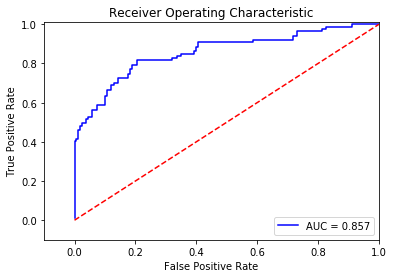

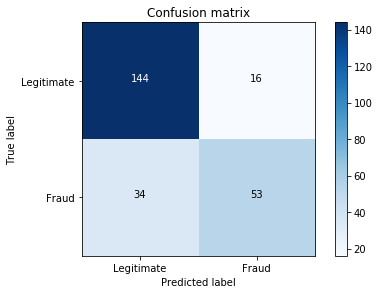

In [67]:
# plot the confusion matrix
cnf_matrix_lr = confusion_matrix(true_values, predictions)
class_names = ['Legitimate','Fraud']

# plot the AUC ROC curve
y_pred_score_log = lr.decision_function(data.iloc[nrows:,0:7])
fpr_log, tpr_log, thresholds = roc_curve(true_values, y_pred_score_log)
roc_auc_log = auc(fpr_log,tpr_log)
print('AUC ROC: ',roc_auc_log)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_log, tpr_log, 'b',label='AUC = %0.3f'% roc_auc_log)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, title='Confusion matrix')

In [68]:
test = pd.read_csv('test.csv')

In [69]:
test.isnull().sum(axis=0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [70]:
test.drop(['PassengerId','Ticket','Name','Cabin'],inplace=True,axis=1)

In [71]:
print(test.shape)

(418, 7)


In [72]:
# knn requires all data to be numerical. We will convert Pclass, Sex and Embarked to dummy encoded variables
dm_test_pclass = pd.get_dummies(test.loc[:,'Pclass'],prefix='Pclass')
dm_test_sex = pd.get_dummies(test.loc[:,'Sex'],prefix='Sex')
dm_test_embarked = pd.get_dummies(test.loc[:,'Embarked'],prefix='Embarked')

test_ohe = pd.concat([test, dm_test_pclass, dm_test_sex, dm_test_embarked], axis=1)
test_ohe.drop(['Pclass','Sex','Embarked'],inplace=True,axis=1)
print(test_ohe.shape)

(418, 12)


In [73]:
# get missing value information
import numpy as np
print(test_ohe.isnull().sum(axis=0))
print(np.isfinite(test_ohe.values).sum(axis=0))
print((np.isfinite(test_ohe.values) | np.isnan(test_ohe.values)).sum(axis=0))
print(test_ohe.shape)

Age           86
SibSp          0
Parch          0
Fare           1
Pclass_1       0
Pclass_2       0
Pclass_3       0
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64
[332 418 418 417 418 418 418 418 418 418 418 418]
[418 418 418 418 418 418 418 418 418 418 418 418]
(418, 12)


In [83]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
test_ohe.loc[np.logical_not(test_ohe.isnull().any(axis=1)),['SibSp', 'Parch', 'Fare']] = min_max.fit_transform(test_ohe.loc[np.logical_not(test_ohe.isnull().any(axis=1)),['SibSp', 'Parch', 'Fare']])

In [85]:
# new predictions
new_age_predictions = imputer.predict(test_ohe.loc[test_ohe.isnull().any(axis=1),['SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S']])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').